# The problem

Break and enter crime become a nighmare for commercials in Toronto. Criminals know how to get into and nothing can stop them.

A security technology company has developed a new kind of security doors and  surveillance system that will can avoid that kind of crime in Toronto. The company wants to focus on commercial located in neighborhoods that have presented breaking and entering in 2019, that information is part of tha market study. The study need information from the last year in order to know the neighborhoods where occur that kind of crime.

Police department have a lot of information abour crimes in Toronto.  In this problem, We will use crime data and foursquare´s data in order to design a comercial plan.

# Information source

- Toronto police open data about crimes: https://data.torontopolice.on.ca/pages/catalogue
- Location and kind of potential customers in Toronto: Foursquare API
- Toronto neighborhoods coordinates https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

# Data

## Toronto Police - Break and enter dataset 

This dataset have the following data:

- Index, Record Unique Identifier,1
- event_unique_id, Event Unique Identifier,2
- occurrencedate, Date of occurrence,3
- reporteddate, Date occurrence was reported,4
- premisetype, Premise where occurrence took place,5
- ucr_code, URC Code,6
- ucr_ext, URC Code Extension,7
- offence, Offence related to the occurrence,8
- reportedyear, Year occurrence was reported,9
- reportedmonth, Month occurrence was reported,10
- reportedday, Day occurrence was reported,11
- reporteddayofyear, Day of week occurrence was reported,12
- reporteddayofweek, Day of year Occurrence was reported,13
- reportedhour, Hour occurrence was reported,14
- occurrenceyear, Occurrence year,15
- occurrencemonth, Occurrence month,16
- occurrenceday, Occurrence day,17
- occurrencedayofyear, Occurrence day of year,18
- occurrencedayofweek, Occurrence day of week,19
- occurrencehour, Occurrence hour,20
- MCI, Major Crime Indicator related to the offence,21
- Division, Division where event occurred,22
- Hood_ID, Neighbourhood Name,23
- Neighbourhood, Neighbourhood Identificator,24
- Long, Longitude of point extracted after offsetting X and & Coordinates to nearest intersection node,25
- Lat, Latitude of point extracted after offsetting X and & Coordinates to nearest intersection node,26

## Foursquare dataset 

This dataset have the information about venues. It will be usefull to know potential customers. 

# Methodology

1. First we get the data from Toronto Police Department and filtered in order to have only data of 2019 and crimes related with break and enter to commercials.
2. Analyze and rank Toronto neighborhoods based on reported crimes
3. Join data in order to know potential customers
4. Give information about potential customers using a map and summary tables

## Data exploration

### Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
from bs4 import BeautifulSoup
import requests

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import geocoder

import matplotlib.pyplot as plt

!pip install opencage

from opencage.geocoder import OpenCageGeocode

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


# Download and Explore Dataset

In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains 'break and entre' crime data in 2019 and the neighborhoods that exist, the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://data.torontopolice.on.ca/pages/break-and-enter


#### Transform the data into a *pandas* dataframe


In [2]:
toronto_df = pd.read_csv('/Users/fabiancamargo/Downloads/Break_and_Enter_2014_to_2019.csv')
toronto_df.shape

(43302, 27)

Quickly examine the resulting dataframe:

In [3]:
toronto_df.head()

Index_ event_unique_id  occurrencedate   reporteddate premisetype  \
0     714  GO-20141857431   1397050200000  1397050740000       House   
1     715  GO-20141859201   1397055600000  1397067540000       House   
2     716  GO-20141866077   1397134800000  1397157060000       House   
3     719  GO-20141915866   1397816160000  1397844000000  Commercial   
4     724  GO-20141965079   1398545460000  1398545460000       House   

   ucr_code  ucr_ext       offence  reportedyear reportedmonth  reportedday  \
0      2120      200           B&E          2014         April            9   
1      2120      200           B&E          2014         April            9   
2      2120      220  B&E W'Intent          2014         April           10   
3      2120      200           B&E          2014         April           18   
4      2120      200           B&E          2014         April           26   

   reporteddayofyear reporteddayofweek  reportedhour  occurrenceyear  \
0                 99        Wednesday             13          2014.0   
1                 99        Wednesday             18          2014.0   
2                100        Thursday              19          2014.0   
3                108        Friday                18          2014.0   
4                116        Saturday              20          2014.0   

  occurrencemonth  occurrenceday  occurrencedayofyear occurrencedayofweek  \
0           April            9.0                 99.0          Wednesday    
1           April            9.0                 99.0          Wednesday    
2           April           10.0                100.0          Thursday     
3           April           18.0                108.0          Friday       
4           April           26.0                116.0          Saturday     

   occurrencehour              MCI Division  Hood_ID  \
0              13  Break and Enter      D22       11   
1              15  Break and Enter      D33       47   
2              13  Break and Enter      D55       69   
3              10  Break and Enter      D53       98   
4              20  Break and Enter      D53       41   

                            Neighbourhood       Long        Lat  ObjectId  
0     Eringate-Centennial-West Deane (11) -79.582176  43.661335         1  
1                 Don Valley Village (47) -79.362968  43.773071         2  
2                        Blake-Jones (69) -79.332382  43.681484         3  
3                Rosedale-Moore Park (98) -79.386787  43.670227         4  
4  Bridle Path-Sunnybrook-York Mills (41) -79.381180  43.725376         5

Torondo_df dataframe only have 'break and enter' crimes from 2014 to 2019. The datafrane have the columns that we need to resolve this problem:
- Neighbourhood column
- Long and Lat columns for geographic coordinates
- reportedyear columns for year
- premisetype column for type of property

The dataset have 43302 rows. We only need rows with year = 2019 ant premisetype = Comercial

In [4]:
toronto_df = toronto_df[(toronto_df['premisetype']=='Commercial') & (toronto_df['reportedyear']==2019)] 
toronto_df.head()

Index_ event_unique_id  occurrencedate   reporteddate premisetype  \
27000  132303   GO-2019937686   1558585380000  1558585380000  Commercial   
27002  132307   GO-2019855582   1557514800000  1557572280000  Commercial   
27009  132320   GO-2019334265   1550775600000  1550832660000  Commercial   
27010  132321   GO-2019463207   1552510800000  1552555020000  Commercial   
27031  131558  GO-20199017508   1559737200000  1559745060000  Commercial   

       ucr_code  ucr_ext offence  reportedyear reportedmonth  reportedday  \
27000      2120      200     B&E          2019           May           23   
27002      2120      200     B&E          2019           May           11   
27009      2120      200     B&E          2019      February           22   
27010      2120      200     B&E          2019         March           14   
27031      2120      200     B&E          2019          June            5   

       reporteddayofyear reporteddayofweek  reportedhour  occurrenceyear  \
27000                143        Thursday               4          2019.0   
27002                131        Saturday              10          2019.0   
27009                 53        Friday                10          2019.0   
27010                 73        Thursday               9          2019.0   
27031                156        Wednesday             14          2019.0   

      occurrencemonth  occurrenceday  occurrencedayofyear occurrencedayofweek  \
27000             May           23.0                143.0          Thursday     
27002             May           10.0                130.0          Friday       
27009        February           21.0                 52.0          Thursday     
27010           March           13.0                 72.0          Wednesday    
27031            June            5.0                156.0          Wednesday    

       occurrencehour              MCI Division  Hood_ID  \
27000               4  Break and Enter      D41      126   
27002              19  Break and Enter      D43      136   
27009              19  Break and Enter      D55       65   
27010              21  Break and Enter      D51       72   
27031              12  Break and Enter      D52       76   

                  Neighbourhood       Long        Lat  ObjectId  
27000         Dorset Park (126) -79.281075  43.765804     27001  
27002           West Hill (136) -79.186867  43.770615     27003  
27009    Greenwood-Coxwell (65) -79.323990  43.671844     27010  
27010          Regent Park (72) -79.364464  43.655617     27011  
27031  Bay Street Corridor (76) -79.383423  43.662140     27032

In [5]:
toronto_df.shape

(3263, 27)

## Summarising the Data



In [6]:
# How many rows the dataset
print ('Dataset contains {} rows.'.format(toronto_df['Index_'].count()))

Dataset contains 3263 rows.


In [7]:
# How many entries are there for each month?
print ('B&E crimes by month:')
toronto_df['reportedmonth'].value_counts()

B&E crimes by month:


July         316
April        295
September    290
January      289
August       282
May          280
October      272
November     264
June         261
December     244
March        239
February     231
Name: reportedmonth, dtype: int64

In [8]:
# How many entries are there for each neigborhood?
print ('B&E crimes by neigborhood:')
toronto_df['Neighbourhood'].value_counts()

B&E crimes by neigborhood:


Kensington-Chinatown (78)                   199
Church-Yonge Corridor (75)                  156
Waterfront Communities-The Island (77)      136
Bay Street Corridor (76)                    123
Dovercourt-Wallace Emerson-Junction (93)    107
Annex (95)                                  104
Moss Park (73)                               96
West Humber-Clairville (1)                   90
Islington-City Centre West (14)              67
Trinity-Bellwoods (81)                       66
Milliken (130)                               65
South Riverdale (70)                         65
York University Heights (27)                 56
Agincourt South-Malvern West (128)           56
Yorkdale-Glen Park (31)                      56
Niagara (82)                                 51
Wexford/Maryvale (119)                       50
Downsview-Roding-CFB (26)                    50
Humbermede (22)                              48
Woburn (137)                                 46
University (79)                         

## Creating a new dataframe grouping data for neighborhood

In [9]:
# creating new data frame grouped by neighbourhood and total crimes
df_group = toronto_df.groupby('Neighbourhood', as_index=False).agg({"Index_": "count"})
df_group=df_group.rename(columns = {'Neighbourhood': 'neighborhood','Index_': 'tot_crimes'}, inplace = False)
df_group.head()

neighborhood  tot_crimes
0               Agincourt North (129)          13
1  Agincourt South-Malvern West (128)          56
2                      Alderwood (20)          13
3                          Annex (95)         104
4              Banbury-Don Mills (42)          11

### Cleaning data

The neighborhood column have the name of neighborhood and his code. We will need only neighborhood´s name. Spliting values help us to get a column only with the name.

In [10]:
#define a funtion to split column
def split_list_like(df: pd.DataFrame, col: str, new_col_prefix: str, pat: str = None):
    df = df.copy()
    split_col = df[col].str.split(pat, expand=True)

    return df.assign(
        **{
            f"{new_col_prefix}_{x}": split_col.iloc[:, x]
            for x in range(split_col.shape[1])
        }
    )

In [11]:
# split the neighborhood column
df_group= df_group.pipe(split_list_like,col="neighborhood", new_col_prefix="neighborhood_num",pat="(",)
df_group.head()

neighborhood  tot_crimes  \
0               Agincourt North (129)          13   
1  Agincourt South-Malvern West (128)          56   
2                      Alderwood (20)          13   
3                          Annex (95)         104   
4              Banbury-Don Mills (42)          11   

              neighborhood_num_0 neighborhood_num_1 neighborhood_num_2  
0               Agincourt North                129)               None  
1  Agincourt South-Malvern West                128)               None  
2                     Alderwood                 20)               None  
3                         Annex                 95)               None  
4             Banbury-Don Mills                 42)               None

In [12]:
#delete unnecessary columns
del df_group ['neighborhood']
del df_group ['neighborhood_num_1']
del df_group ['neighborhood_num_2']
df_group=df_group.rename(columns = {'neighborhood_num_0': 'neighborhood','Index_': 'tot_crimes'}, inplace = False)
df_group.head()

tot_crimes                   neighborhood
0          13               Agincourt North 
1          56  Agincourt South-Malvern West 
2          13                     Alderwood 
3         104                         Annex 
4          11             Banbury-Don Mills

#### We will use another geocoding tool, this is opencage. Then we get the latitude and longitude of neigborhoods 

In [13]:
key = "65d2ea88fcec49ecae373d4903ecd72d"  
geocoder = OpenCageGeocode(key)

In [14]:
list_lat = []   # create empty lists
list_long = []

City = 'Toronto'
Country = 'Canada' 

for index, row in df_group.iterrows(): # iterate over rows in dataframe
  
    neigborhood = row['neighborhood']
    query = str(neigborhood)+','+str(City)+','+str(Country)

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']


    list_lat.append(lat)
    list_long.append(long)
# create new columns from lists    

df_group['lat'] = list_lat   

df_group['long'] = list_long

df_group.head()

tot_crimes                   neighborhood        lat       long
0          13               Agincourt North   43.808038 -79.266439
1          56  Agincourt South-Malvern West   43.663280 -79.466170
2          13                     Alderwood   43.601717 -79.545232
3         104                         Annex   43.670338 -79.407117
4          11             Banbury-Don Mills   43.734804 -79.357243

## Create a map of Toronto with B&E crimes on top.

#### Use geopy library to get the latitude and longitude values of Toronto

In [15]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [16]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(toronto_df['Lat'], toronto_df['Long'], toronto_df['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Create a map of Toronto with B&E crimes count by neigborhood on top.

In [17]:
# create map of Toronto with B&E crimes count by neigborhood using latitude and longitude values
map_toronto2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, tot_crimes in zip(df_group['lat'], df_group['long'], df_group['neighborhood'], df_group['tot_crimes']):
    label = '{}'.format(neighborhood +', b&e crimes: '+ str(tot_crimes))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto2)  
    
map_toronto2

### Let's check out the 20 neigborhoods with the highest amount of B&E crimes

In [18]:
df_group.sort_values(['tot_crimes'], ascending=False, axis=0, inplace=True)

# get the top 10 entries
df_top = df_group.head(20)
df_top

tot_crimes                          neighborhood        lat       long
61          199                 Kensington-Chinatown   43.654378 -79.398899
23          156                Church-Yonge Corridor   43.679919 -79.388689
120         136    Waterfront Communities-The Island   43.700110 -79.416300
6           123                  Bay Street Corridor   43.665272 -79.387531
32          107  Dovercourt-Wallace Emerson-Junction   43.700110 -79.416300
3           104                                Annex   43.670338 -79.407117
77           96                            Moss Park   43.654644 -79.369728
122          90               West Humber-Clairville   43.700110 -79.416300
57           67           Islington-City Centre West   43.648795 -79.549000
117          66                    Trinity-Bellwoods   43.647565 -79.413881
108          65                      South Riverdale   43.665470 -79.352594
74           65                             Milliken   43.823174 -79.301763
1            56         Agincourt South-Malvern West   43.663280 -79.466170
137          56                   Yorkdale-Glen Park   43.710434 -79.453340
136          56              York University Heights   43.758781 -79.519434
85           51                              Niagara   43.644075 -79.408698
126          50                     Wexford/Maryvale   43.700110 -79.416300
33           50                 Downsview-Roding-CFB   43.700110 -79.416300
54           48                           Humbermede   43.700110 -79.416300
130          46                               Woburn   43.759824 -79.225291

### Create a pie chart for the 10 neigborhoods with the highest amount of B&E crimes

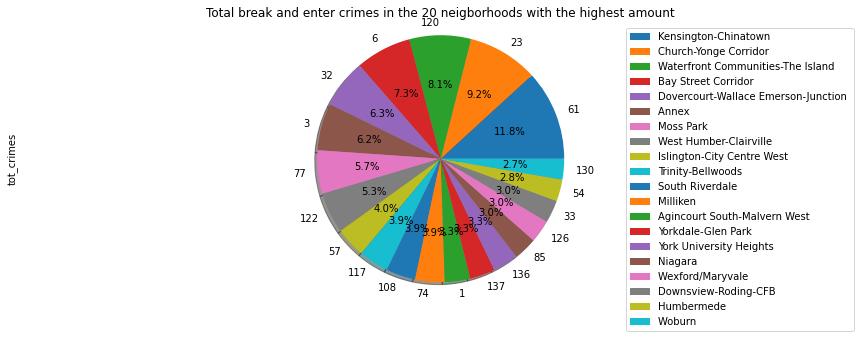

In [19]:
df_top['tot_crimes'].plot(kind='pie',
                            figsize=(15, 5),
                            autopct='%1.1f%%', # add in percentages
                            startangle=0,     
                            shadow=True,       # add shadow
                            )
plt.title('Total break and enter crimes in the 20 neigborhoods with the highest amount')
plt.axis('equal') # Sets the pie chart to look like a circle.
plt.legend(labels=df_top.neighborhood, loc='best') 
plt.show()

### ...better to use a bar char:

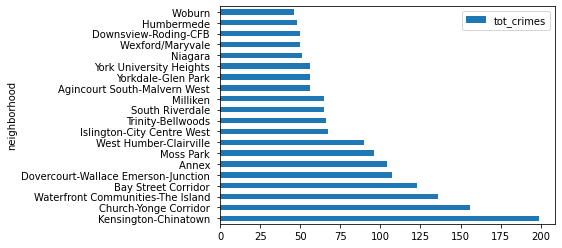

In [20]:
ax = df_top.plot.barh(x='neighborhood', y='tot_crimes')

### The market study will focus in this 20 neighborhoods. We will use Foursquare to get potential customers

In [21]:
CLIENT_ID = 'UVOTY3SJSHEQ0T04KNEN15NKHUUMJRBHH3S0IOEZZBTD4XSI' # your Foursquare ID
CLIENT_SECRET = 'YTRUN51TSHBWA3HGF1LPFPOSGS544B4VCQUWW1FQDO15OTPP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Function to get venues in the list of neighborhoods

In [22]:
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
potential_customers = getNearbyVenues(names=df_top['neighborhood'],
                                   latitudes=df_top['lat'],
                                   longitudes=df_top['long'],
                                   radius=500
                                  )

Kensington-Chinatown 
Church-Yonge Corridor 
Waterfront Communities-The Island 
Bay Street Corridor 
Dovercourt-Wallace Emerson-Junction 
Annex 
Moss Park 
West Humber-Clairville 
Islington-City Centre West 
Trinity-Bellwoods 
South Riverdale 
Milliken 
Agincourt South-Malvern West 
Yorkdale-Glen Park 
York University Heights 
Niagara 
Wexford/Maryvale 
Downsview-Roding-CFB 
Humbermede 
Woburn 


In [24]:
potential_customers.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Kensington-Chinatown               43.654378              -79.398899   
1  Kensington-Chinatown               43.654378              -79.398899   
2  Kensington-Chinatown               43.654378              -79.398899   
3  Kensington-Chinatown               43.654378              -79.398899   
4  Kensington-Chinatown               43.654378              -79.398899   

                            Venue  Venue Latitude  Venue Longitude  \
0        Essence of Life Organics       43.654111       -79.400431   
1  Seven Lives - Tacos y Mariscos       43.654418       -79.400545   
2                    Golden Patty       43.654659       -79.401179   
3             Blackbird Baking Co       43.654764       -79.400566   
4            Banh Mi Nguyen Huong       43.653628       -79.398376   

          Venue Category  
0        Organic Grocery  
1     Mexican Restaurant  
2   Caribbean Restaurant  
3                 Bakery  
4  Vietnamese Restaurant

### Size of data frame

In [25]:
potential_customers.shape

(604, 7)

### check out  how many venues were returned for each neighborhood


In [26]:
potential_customers.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                  
Agincourt South-Malvern West                             48   
Annex                                                    44   
Bay Street Corridor                                      41   
Church-Yonge Corridor                                    43   
Dovercourt-Wallace Emerson-Junction                      15   
Downsview-Roding-CFB                                     15   
Humbermede                                               15   
Islington-City Centre West                                4   
Kensington-Chinatown                                     64   
Milliken                                                 39   
Moss Park                                                54   
Niagara                                                  51   
South Riverdale                                          27   
Trinity-Bellwoods                                        45   
Waterfront Communities-The Island                        15   
West Humber-Clairville                                   15   
Wexford/Maryvale                                         15   
Woburn                                                   25   
York University Heights                                  18   
Yorkdale-Glen Park                                       11   

                                      Neighborhood Longitude  Venue  \
Neighborhood                                                          
Agincourt South-Malvern West                              48     48   
Annex                                                     44     44   
Bay Street Corridor                                       41     41   
Church-Yonge Corridor                                     43     43   
Dovercourt-Wallace Emerson-Junction                       15     15   
Downsview-Roding-CFB                                      15     15   
Humbermede                                                15     15   
Islington-City Centre West                                 4      4   
Kensington-Chinatown                                      64     64   
Milliken                                                  39     39   
Moss Park                                                 54     54   
Niagara                                                   51     51   
South Riverdale                                           27     27   
Trinity-Bellwoods                                         45     45   
Waterfront Communities-The Island                         15     15   
West Humber-Clairville                                    15     15   
Wexford/Maryvale                                          15     15   
Woburn                                                    25     25   
York University Heights                                   18     18   
Yorkdale-Glen Park                                        11     11   

                                      Venue Latitude  Venue Longitude  \
Neighborhood                                                            
Agincourt South-Malvern West                      48               48   
Annex                                             44               44   
Bay Street Corridor                               41               41   
Church-Yonge Corridor                             43               43   
Dovercourt-Wallace Emerson-Junction               15               15   
Downsview-Roding-CFB                              15               15   
Humbermede                                        15               15   
Islington-City Centre West                         4                4   
Kensington-Chinatown                              64               64   
Milliken                                          39               39   
Moss Park                                         54               54   
Niagara                                           51               51   
South Riverdale                                   27              

In [27]:
potential_customers.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Kensington-Chinatown               43.654378              -79.398899   
1  Kensington-Chinatown               43.654378              -79.398899   
2  Kensington-Chinatown               43.654378              -79.398899   
3  Kensington-Chinatown               43.654378              -79.398899   
4  Kensington-Chinatown               43.654378              -79.398899   

                            Venue  Venue Latitude  Venue Longitude  \
0        Essence of Life Organics       43.654111       -79.400431   
1  Seven Lives - Tacos y Mariscos       43.654418       -79.400545   
2                    Golden Patty       43.654659       -79.401179   
3             Blackbird Baking Co       43.654764       -79.400566   
4            Banh Mi Nguyen Huong       43.653628       -79.398376   

          Venue Category  
0        Organic Grocery  
1     Mexican Restaurant  
2   Caribbean Restaurant  
3                 Bakery  
4  Vietnamese Restaurant

### Let's find out how many unique categories can be curated from all the returned venues

In [28]:
print('There are {} uniques categories.'.format(len(potential_customers['Venue Category'].unique())))

There are 162 uniques categories.


## Analyze Each Neighborhood

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(potential_customers[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
toronto_onehot.insert(loc=0, column='Neighborhood', value=potential_customers['Neighborhood'] )
toronto_onehot.head()

Neighborhood  Accessories Store  American Restaurant  \
0  Kensington-Chinatown                   0                    0   
1  Kensington-Chinatown                   0                    0   
2  Kensington-Chinatown                   0                    0   
3  Kensington-Chinatown                   0                    0   
4  Kensington-Chinatown                   0                    0   

   Antique Shop  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0             0            0                    0                 0   
1             0            0                    0                 0   
2             0            0                    0                 0   
3             0            0                    0                 0   
4             0            0                    0                 0   

   Athletics & Sports  BBQ Joint  Bakery  Bank  Bar  Baseball Field  \
0                   0          0       0     0    0               0   
1                   0          0       0     0    0               0   
2                   0          0       0     0    0               0   
3                   0          0       1     0    0               0   
4                   0          0       0     0    0               0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Big Box Store  \
0                0         0           0                   0              0   
1                0         0           0                   0              0   
2                0         0           0                   0              0   
3                0         0           0                   0              0   
4                0         0           0                   0              0   

   Bistro  Bookstore  Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  \
0       0          0               0        0            0                0   
1       0          0               0        0            0                0   
2       0          0               0        0            0                0   
3       0          0               0        0            0                0   
4       0          0               0        0            0                0   

   Burger Joint  Burrito Place  Bus Line  Bus Station  Bus Stop  Butcher  \
0             0              0         0            0         0        0   
1             0              0         0            0         0        0   
2             0              0         0            0         0        0   
3             0              0         0            0         0        0   
4             0              0         0            0         0        0   

   Café  Cajun / Creole Restaurant  Camera Store  Cantonese Restaurant  \
0     0                          0             0                     0   
1     0                          0             0                     0   
2     0                          0             0                     0   
3     0                          0             0                     0   
4     0                          0             0                     0   

   Caribbean Restaurant  Cheese Shop  Chinese Restaurant  Clothing Store  \
0                     0            0                   0               0   
1                     0            0                   0               0   
2                     1            0                   0               0   
3                     0            0                   0               0   
4                     0            0                   0               0   

   Cocktail Bar  Coffee Shop  College Theater  Comfort Food Restaurant  \
0             0            0                0                        0   
1             0            0                0                        0   
2             0            0                0                        0   
3             0            0                0                        0   
4             0            0                0                        0

### And let's examine the new dataframe size.

In [30]:
toronto_onehot.shape

(604, 162)

### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  Accessories Store  \
0         Agincourt South-Malvern West                 0.0   
1                                Annex                 0.0   
2                  Bay Street Corridor                 0.0   
3                Church-Yonge Corridor                 0.0   
4  Dovercourt-Wallace Emerson-Junction                 0.0   

   American Restaurant  Antique Shop  Art Gallery  Arts & Crafts Store  \
0             0.000000      0.041667          0.0             0.020833   
1             0.000000      0.000000          0.0             0.000000   
2             0.000000      0.000000          0.0             0.024390   
3             0.023256      0.000000          0.0             0.000000   
4             0.000000      0.000000          0.0             0.000000   

   Asian Restaurant  Athletics & Sports  BBQ Joint    Bakery      Bank  \
0               0.0            0.000000   0.000000  0.062500  0.000000   
1               0.0            0.000000   0.000000  0.022727  0.000000   
2               0.0            0.000000   0.000000  0.000000  0.000000   
3               0.0            0.023256   0.023256  0.023256  0.023256   
4               0.0            0.000000   0.000000  0.000000  0.000000   

        Bar  Baseball Field  Bed & Breakfast  Beer Bar  Beer Store  \
0  0.062500             0.0              0.0   0.00000    0.000000   
1  0.000000             0.0              0.0   0.00000    0.000000   
2  0.000000             0.0              0.0   0.02439    0.000000   
3  0.023256             0.0              0.0   0.00000    0.023256   
4  0.000000             0.0              0.0   0.00000    0.000000   

   Belgian Restaurant  Big Box Store    Bistro  Bookstore  Breakfast Spot  \
0                 0.0            0.0  0.000000   0.020833             0.0   
1                 0.0            0.0  0.045455   0.022727             0.0   
2                 0.0            0.0  0.000000   0.024390             0.0   
3                 0.0            0.0  0.000000   0.000000             0.0   
4                 0.0            0.0  0.000000   0.000000             0.0   

   Brewery  Bridal Shop  Bubble Tea Shop  Burger Joint  Burrito Place  \
0      0.0          0.0          0.00000           0.0       0.000000   
1      0.0          0.0          0.00000           0.0       0.022727   
2      0.0          0.0          0.04878           0.0       0.000000   
3      0.0          0.0          0.00000           0.0       0.000000   
4      0.0          0.0          0.00000           0.0       0.000000   

   Bus Line  Bus Station  Bus Stop   Butcher      Café  \
0  0.000000          0.0       0.0  0.000000  0.083333   
1  0.000000          0.0       0.0  0.000000  0.000000   
2  0.000000          0.0       0.0  0.000000  0.048780   
3  0.000000          0.0       0.0  0.023256  0.046512   
4  0.066667          0.0       0.0  0.000000  0.066667   

   Cajun / Creole Restaurant  Camera Store  Cantonese Restaurant  \
0                   0.020833           0.0                   0.0   
1                   0.000000           0.0                   0.0   
2                   0.000000           0.0                   0.0   
3                   0.000000           0.0                   0.0   
4                   0.000000           0.0                   0.0   

   Caribbean Restaurant  Cheese Shop  Chinese Restaurant  Clothing Store  \
0               0.00000          0.0            0.000000             0.0   
1               0.00000          0.0            0.000000             0.0   
2               0.02439          0.0            0.024390             0.0   
3               0.00000          0.0            0.000000             0.0   
4               0.00000          0.0            0.066667             0.0   

   Cocktail Bar  Coffee Shop  College Theater  Comfort Food Restaurant  \
0           0.0     0.000000          0.00000                      0.0   
1           0.0     0.068182          0.00000                      0.0   
2   

#### Print each neighborhood along with the top 5 most common venues

In [32]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt South-Malvern West ----
                venue  freq
0                Café  0.08
1              Bakery  0.06
2                 Bar  0.06
3     Thai Restaurant  0.06
4  Italian Restaurant  0.06


----Annex ----
           venue  freq
0    Coffee Shop  0.07
1  Grocery Store  0.07
2    Pizza Place  0.07
3            Gym  0.05
4         Bistro  0.05


----Bay Street Corridor ----
                      venue  freq
0          Sushi Restaurant  0.07
1       Japanese Restaurant  0.05
2           Bubble Tea Shop  0.05
3  Mediterranean Restaurant  0.05
4                      Café  0.05


----Church-Yonge Corridor ----
                venue  freq
0  Italian Restaurant  0.07
1                Café  0.05
2         Coffee Shop  0.05
3                Park  0.05
4                 Gym  0.05


----Dovercourt-Wallace Emerson-Junction ----
                  venue  freq
0    Italian Restaurant  0.13
1  Gym / Fitness Center  0.07
2           Coffee Shop  0.07
3                  Café  0.07
4    C

#### Put results into a *pandas* dataframe

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0         Agincourt South-Malvern West                   Café   
1                                Annex          Grocery Store   
2                  Bay Street Corridor       Sushi Restaurant   
3                Church-Yonge Corridor     Italian Restaurant   
4  Dovercourt-Wallace Emerson-Junction     Italian Restaurant   

  2nd Most Common Venue     3rd Most Common Venue 4th Most Common Venue  \
0       Thai Restaurant                    Bakery                   Bar   
1           Pizza Place               Coffee Shop                Bistro   
2       Bubble Tea Shop  Mediterranean Restaurant                  Café   
3           Coffee Shop                       Spa                  Café   
4                Garden      Gym / Fitness Center           Coffee Shop   

  5th Most Common Venue  6th Most Common Venue 7th Most Common Venue  \
0    Italian Restaurant            Flea Market          Antique Shop   
1       Thai Restaurant                    Gym        Ice Cream Shop   
2   Japanese Restaurant  Portuguese Restaurant            Poke Place   
3                   Gym                   Park      Sushi Restaurant   
4          Dance Studio     Chinese Restaurant              Pharmacy   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0    Mexican Restaurant         Grocery Store              Irish Pub  
1              Pharmacy         Burrito Place     Italian Restaurant  
2    Persian Restaurant                  Park   Caribbean Restaurant  
3         Grocery Store             Pet Store      Convenience Store  
4                  Café              Bus Line    Japanese Restaurant

### Making Clusters for Neighborhood

Run *k*-means to cluster the neighborhood into 5 clusters.

In [35]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 0, 0, 0, 2, 1, 3], dtype=int32)

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [36]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [37]:
toronto_merged = df_top

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')

toronto_merged.head() # check the last columns!

tot_crimes                          neighborhood        lat       long  \
61          199                 Kensington-Chinatown   43.654378 -79.398899   
23          156                Church-Yonge Corridor   43.679919 -79.388689   
120         136    Waterfront Communities-The Island   43.700110 -79.416300   
6           123                  Bay Street Corridor   43.665272 -79.387531   
32          107  Dovercourt-Wallace Emerson-Junction   43.700110 -79.416300   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
61                1           Coffee Shop                  Café   
23                1    Italian Restaurant           Coffee Shop   
120               0    Italian Restaurant                Garden   
6                 1      Sushi Restaurant       Bubble Tea Shop   
32                0    Italian Restaurant                Garden   

        3rd Most Common Venue          4th Most Common Venue  \
61         Mexican Restaurant  Vegetarian / Vegan Restaurant   
23                        Spa                           Café   
120      Gym / Fitness Center                    Coffee Shop   
6    Mediterranean Restaurant                           Café   
32       Gym / Fitness Center                    Coffee Shop   

    5th Most Common Venue  6th Most Common Venue 7th Most Common Venue  \
61                    Bar            Gaming Cafe         Grocery Store   
23                    Gym                   Park      Sushi Restaurant   
120          Dance Studio     Chinese Restaurant              Pharmacy   
6     Japanese Restaurant  Portuguese Restaurant            Poke Place   
32           Dance Studio     Chinese Restaurant              Pharmacy   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
61           Burger Joint           Pizza Place                 Bakery  
23          Grocery Store             Pet Store      Convenience Store  
120                  Café              Bus Line    Japanese Restaurant  
6      Persian Restaurant                  Park   Caribbean Restaurant  
32                   Café              Bus Line    Japanese Restaurant

#### Finally, let's visualize the resulting clusters

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['lat'], toronto_merged['long'], toronto_merged['neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

#### Cluster 1

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

neighborhood 1st Most Common Venue  \
120    Waterfront Communities-The Island     Italian Restaurant   
32   Dovercourt-Wallace Emerson-Junction     Italian Restaurant   
122               West Humber-Clairville     Italian Restaurant   
126                     Wexford/Maryvale     Italian Restaurant   
33                  Downsview-Roding-CFB     Italian Restaurant   
54                            Humbermede     Italian Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
120                Garden  Gym / Fitness Center           Coffee Shop   
32                 Garden  Gym / Fitness Center           Coffee Shop   
122                Garden  Gym / Fitness Center           Coffee Shop   
126                Garden  Gym / Fitness Center           Coffee Shop   
33                 Garden  Gym / Fitness Center           Coffee Shop   
54                 Garden  Gym / Fitness Center           Coffee Shop   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
120          Dance Studio    Chinese Restaurant              Pharmacy   
32           Dance Studio    Chinese Restaurant              Pharmacy   
122          Dance Studio    Chinese Restaurant              Pharmacy   
126          Dance Studio    Chinese Restaurant              Pharmacy   
33           Dance Studio    Chinese Restaurant              Pharmacy   
54           Dance Studio    Chinese Restaurant              Pharmacy   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
120                  Café              Bus Line    Japanese Restaurant  
32                   Café              Bus Line    Japanese Restaurant  
122                  Café              Bus Line    Japanese Restaurant  
126                  Café              Bus Line    Japanese Restaurant  
33                   Café              Bus Line    Japanese Restaurant  
54                   Café              Bus Line    Japanese Restaurant

#### Cluster 2

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

neighborhood 1st Most Common Venue  \
61           Kensington-Chinatown            Coffee Shop   
23          Church-Yonge Corridor     Italian Restaurant   
6             Bay Street Corridor       Sushi Restaurant   
3                           Annex          Grocery Store   
77                      Moss Park            Coffee Shop   
117             Trinity-Bellwoods                 Bakery   
1    Agincourt South-Malvern West                   Café   
85                        Niagara            Yoga Studio   

    2nd Most Common Venue     3rd Most Common Venue  \
61                   Café        Mexican Restaurant   
23            Coffee Shop                       Spa   
6         Bubble Tea Shop  Mediterranean Restaurant   
3             Pizza Place               Coffee Shop   
77     Italian Restaurant            Sandwich Place   
117          Cocktail Bar     Vietnamese Restaurant   
1         Thai Restaurant                    Bakery   
85                 Bakery               Pizza Place   

             4th Most Common Venue   5th Most Common Venue  \
61   Vegetarian / Vegan Restaurant                     Bar   
23                            Café                     Gym   
6                             Café     Japanese Restaurant   
3                           Bistro         Thai Restaurant   
77                            Café  Furniture / Home Store   
117                           Café             Coffee Shop   
1                              Bar      Italian Restaurant   
85                    Dessert Shop            Burger Joint   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
61             Gaming Cafe         Grocery Store          Burger Joint   
23                    Park      Sushi Restaurant         Grocery Store   
6    Portuguese Restaurant            Poke Place    Persian Restaurant   
3                      Gym        Ice Cream Shop              Pharmacy   
77                   Diner             BBQ Joint                 Hotel   
117                    Bar            Kids Store               Brewery   
1              Flea Market          Antique Shop    Mexican Restaurant   
85                    Café                   Spa           Coffee Shop   

    9th Most Common Venue 10th Most Common Venue  
61            Pizza Place                 Bakery  
23              Pet Store      Convenience Store  
6                    Park   Caribbean Restaurant  
3           Burrito Place     Italian Restaurant  
77          Grocery Store       Sushi Restaurant  
117            Restaurant       Greek Restaurant  
1           Grocery Store              Irish Pub  
85     Light Rail Station     Italian Restaurant

#### Cluster 3

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

neighborhood 1st Most Common Venue 2nd Most Common Venue  \
57  Islington-City Centre West            Pizza Place                  Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
57     Fish & Chips Shop           Yoga Studio          Dance Studio   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
57        Discount Store                 Diner    Dim Sum Restaurant   

   9th Most Common Venue 10th Most Common Venue  
57          Dessert Shop          Design Studio

#### Cluster 4

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

neighborhood  1st Most Common Venue 2nd Most Common Venue  \
108  South Riverdale   Vietnamese Restaurant    Chinese Restaurant   
74          Milliken      Chinese Restaurant   Japanese Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
108  Fast Food Restaurant    Light Rail Station                Bakery   
74                 Bakery    Miscellaneous Shop      Asian Restaurant   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
108         Grocery Store           Fish Market        Ice Cream Shop   
74        Bubble Tea Shop            Food Court         Shopping Mall   

    9th Most Common Venue 10th Most Common Venue  
108        Breakfast Spot                    Bar  
74     Seafood Restaurant              Bookstore

#### Cluster 5


In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

neighborhood 1st Most Common Venue     2nd Most Common Venue  \
137       Yorkdale-Glen Park            Pizza Place  Mediterranean Restaurant   
136  York University Heights   Fast Food Restaurant             Grocery Store   
130                   Woburn   Fast Food Restaurant            Discount Store   

    3rd Most Common Venue      4th Most Common Venue  5th Most Common Venue  \
137         Grocery Store  Latin American Restaurant     Italian Restaurant   
136           Pizza Place             Discount Store  Vietnamese Restaurant   
130           Coffee Shop                       Bank            Bus Station   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
137        Ice Cream Shop  Fast Food Restaurant        Sandwich Place   
136   Fried Chicken Joint        Sandwich Place          Liquor Store   
130           Pizza Place              Pharmacy     Indian Restaurant   

          9th Most Common Venue 10th Most Common Venue  
137  Construction & Landscaping            Gas Station  
136                 Gas Station               Pharmacy  
130              Sandwich Place      Electronics Store

# Conclusions

## More interesting neighborhoods 

- Remember that the analysis cover the neigbourhoods with high number of break and entrance crimes. 
- Now we know: clusters 1 and 2 have a lot of categories most of these related to food like restaurants and coffe shops and other categories like gyms and stores.
- So, this is a very interesting information that can be used addrresing to make a marketing campaig segmented to a kind of commerce: food related venues 

### Calculate total crimes by cluster

In [44]:
#create dataframes for cluster 1 and 2
df1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
df2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
tot_crimes_cluster1=df1['tot_crimes'].sum()
tot_crimes_cluster2=df2['tot_crimes'].sum()

print("Total crimes in Cluster 1: "+ str(tot_crimes_cluster1))
print("Total crimes in Cluster 2: "+ str(tot_crimes_cluster2))

Total crimes in Cluster 1: 481
Total crimes in Cluster 2: 851


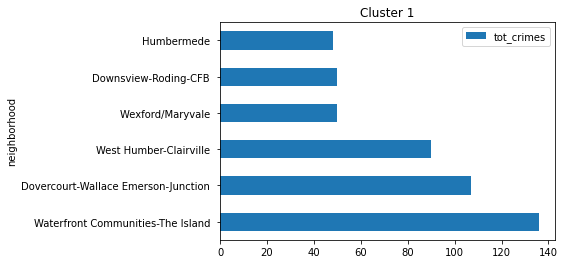

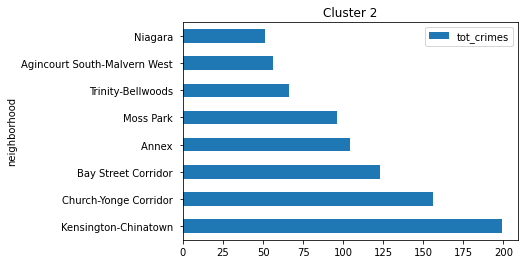

In [45]:
ax = df1.plot.barh(x='neighborhood', y='tot_crimes',title='Cluster 1')
ax = df2.plot.barh(x='neighborhood', y='tot_crimes',title='Cluster 2')

Now we know:
- The difference between cluster 1 and 2 is to high. Cluster 2 have almost double of cluster 1

Maybe, we will have more worried customers in neighborhoods of cluster 2

## Now we can communicate to marketing department some tips

- 1. It is possible to find a high quantity of customers in the neighborhoods grouped in clusters 1 and 2
- 2. Customers in cluster 2 have a big problem with 'break and enter' crime in comparison with customers of cluster 1
- 3. In both cases there are comercial venues related with food.
- 4. It is possible to create a segmented comercial campaign based on the location and type of business.